In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 경로 지정

In [3]:
HOME_ROOT = "/home/jovyan"

## DATA
DATA_ROOT = os.path.join(HOME_ROOT, "datasets/tadpole_frog_v4_THRES_0.6") # DATA ROOT 경로
TRAIN_DATA = os.path.join(DATA_ROOT, "train")
VAL_DATA = os.path.join(DATA_ROOT, "valid")
TEST_DATA = os.path.join(DATA_ROOT, "test")

## WEIGHT
WEIGHT_NAME = "tadpole_frog_v4_THRES_0.6.pth"
WEIGHT_SAVE_PATH = os.path.join(HOME_ROOT, "weights/ambiguous_exp", WEIGHT_NAME) # WEIGHT 파일 

## transforms

In [4]:
resize = 224
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

## Load Dataset

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA, transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root=VAL_DATA, transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_DATA, transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


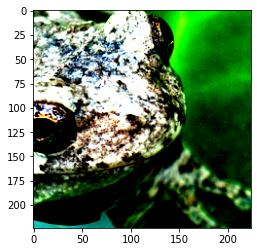

In [6]:
from PIL import Image

img_sample = train_dataset[20][0]
plt.imshow(img_sample.permute(1, 2, 0))

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

## Load ResNet50

In [8]:
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(2048, 2)
resnet50 = resnet50.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-3)

## Train

In [10]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print(f"Epoch {epoch + 1}/{num_epoch}")
        print("-" * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()                
    
    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}")
    print(f"Best val Acc: {best_acc:4f}")
    
    return model

In [ ]:
import time

num_epoch = 300
model = train_model(resnet50, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


train Loss: 1.2593 Acc: 0.6375


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 2.6033 Acc: 0.4190
Epoch 2/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.5716 Acc: 0.7163


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 1.3000 Acc: 0.5140
Epoch 3/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.4896 Acc: 0.7650


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.9553 Acc: 0.7486
Epoch 4/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.4419 Acc: 0.7900


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


val Loss: 0.7204 Acc: 0.7374
Epoch 5/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.4164 Acc: 0.8013


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.7336 Acc: 0.7542
Epoch 6/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.4264 Acc: 0.8150


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.6704 Acc: 0.6704
Epoch 7/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


train Loss: 0.4157 Acc: 0.8137


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.6870 Acc: 0.7654
Epoch 8/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


train Loss: 0.3851 Acc: 0.8163


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.6232 Acc: 0.7542
Epoch 9/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.3565 Acc: 0.8325


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


val Loss: 0.9547 Acc: 0.7430
Epoch 10/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.3720 Acc: 0.8375


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 0.7555 Acc: 0.7654
Epoch 11/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.4063 Acc: 0.8037


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


val Loss: 1.0540 Acc: 0.7654
Epoch 12/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.3521 Acc: 0.8513


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.6521 Acc: 0.7095
Epoch 13/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.3455 Acc: 0.8450


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


val Loss: 1.1056 Acc: 0.7486
Epoch 14/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.3519 Acc: 0.8488


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


val Loss: 0.6864 Acc: 0.7318
Epoch 15/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.3498 Acc: 0.8337


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 0.7066 Acc: 0.7598
Epoch 16/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.3302 Acc: 0.8538


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.8226 Acc: 0.7765
Epoch 17/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.3098 Acc: 0.8588


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


val Loss: 0.6441 Acc: 0.7095
Epoch 18/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.3061 Acc: 0.8650


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 1.1538 Acc: 0.7598
Epoch 19/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.3177 Acc: 0.8600


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.6559 Acc: 0.7709
Epoch 20/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2834 Acc: 0.8712


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.6942 Acc: 0.7933
Epoch 21/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2989 Acc: 0.8738


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 0.6592 Acc: 0.7709
Epoch 22/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2796 Acc: 0.8850


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 0.6733 Acc: 0.7598
Epoch 23/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2557 Acc: 0.8862


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


val Loss: 0.6369 Acc: 0.7542
Epoch 24/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2665 Acc: 0.8862


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


val Loss: 0.7141 Acc: 0.6927
Epoch 25/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2600 Acc: 0.8938


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


val Loss: 1.2459 Acc: 0.7654
Epoch 26/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2656 Acc: 0.8888


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


val Loss: 0.7977 Acc: 0.7486
Epoch 27/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2401 Acc: 0.9000


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.7424 Acc: 0.7654
Epoch 28/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2453 Acc: 0.8950


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 1.0365 Acc: 0.7430
Epoch 29/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2895 Acc: 0.8838


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.8363 Acc: 0.7765
Epoch 30/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2586 Acc: 0.8912


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 0.9323 Acc: 0.6257
Epoch 31/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2545 Acc: 0.8988


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.7401 Acc: 0.7598
Epoch 32/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.2213 Acc: 0.9150


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.7379 Acc: 0.7989
Epoch 33/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2198 Acc: 0.9150


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.8503 Acc: 0.7709
Epoch 34/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2418 Acc: 0.9012


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 1.0311 Acc: 0.7709
Epoch 35/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2263 Acc: 0.9163


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 1.0824 Acc: 0.7318
Epoch 36/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2377 Acc: 0.8988


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 1.0356 Acc: 0.7821
Epoch 37/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2369 Acc: 0.9000


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


val Loss: 1.4279 Acc: 0.7430
Epoch 38/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2632 Acc: 0.8962


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.8676 Acc: 0.7765
Epoch 39/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2918 Acc: 0.8812


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.6450 Acc: 0.7877
Epoch 40/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.2434 Acc: 0.9062


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.6579 Acc: 0.7709
Epoch 41/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2013 Acc: 0.9150


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 0.8428 Acc: 0.7765
Epoch 42/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2477 Acc: 0.8912


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.7481 Acc: 0.7430
Epoch 43/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.3067 Acc: 0.8538


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.6205 Acc: 0.7598
Epoch 44/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2913 Acc: 0.8738


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.6073 Acc: 0.7598
Epoch 45/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1970 Acc: 0.9250


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.7986 Acc: 0.7933
Epoch 46/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2425 Acc: 0.8975


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


val Loss: 0.7140 Acc: 0.7877
Epoch 58/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.2438 Acc: 0.8938


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.7036 Acc: 0.7486
Epoch 59/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.2102 Acc: 0.9125


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.6615 Acc: 0.7654
Epoch 60/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2487 Acc: 0.8900


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.6351 Acc: 0.7933
Epoch 61/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2122 Acc: 0.9062


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.6101 Acc: 0.7598
Epoch 62/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1892 Acc: 0.9300


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.6227 Acc: 0.7709
Epoch 63/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2094 Acc: 0.9113


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


val Loss: 0.7170 Acc: 0.7709
Epoch 64/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2363 Acc: 0.8975


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 1.1106 Acc: 0.7709
Epoch 65/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2279 Acc: 0.9025


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


val Loss: 0.6890 Acc: 0.7430
Epoch 66/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.1818 Acc: 0.9250


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 0.9274 Acc: 0.7263
Epoch 67/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1564 Acc: 0.9375


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.8469 Acc: 0.7821
Epoch 68/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.1471 Acc: 0.9400


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 0.8668 Acc: 0.7654
Epoch 69/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1906 Acc: 0.9300


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 0.8783 Acc: 0.7654
Epoch 70/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1719 Acc: 0.9375


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.7813 Acc: 0.7765
Epoch 71/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1288 Acc: 0.9450


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


val Loss: 0.8102 Acc: 0.8101
Epoch 72/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1590 Acc: 0.9387


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


val Loss: 0.9236 Acc: 0.7765
Epoch 73/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1467 Acc: 0.9375


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


val Loss: 0.8160 Acc: 0.7877
Epoch 74/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1715 Acc: 0.9225


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 1.0535 Acc: 0.7821
Epoch 75/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1990 Acc: 0.9213


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.9440 Acc: 0.7933
Epoch 76/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.1413 Acc: 0.9487


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


val Loss: 0.8122 Acc: 0.7709
Epoch 77/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1580 Acc: 0.9450


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


val Loss: 1.0991 Acc: 0.7821
Epoch 78/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1526 Acc: 0.9375


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 1.0657 Acc: 0.7765
Epoch 79/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1618 Acc: 0.9363


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 0.8524 Acc: 0.7486
Epoch 80/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2243 Acc: 0.9088


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


val Loss: 0.8250 Acc: 0.7486
Epoch 81/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1407 Acc: 0.9425


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 1.1414 Acc: 0.7821
Epoch 82/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1297 Acc: 0.9513


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 1.0604 Acc: 0.7039
Epoch 83/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.1071 Acc: 0.9625


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 1.1394 Acc: 0.7989
Epoch 84/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1343 Acc: 0.9425


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.8415 Acc: 0.7430
Epoch 85/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1804 Acc: 0.9287


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


val Loss: 3.3846 Acc: 0.7486
Epoch 86/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.2340 Acc: 0.9012


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


val Loss: 4.3045 Acc: 0.7709
Epoch 87/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


train Loss: 0.1732 Acc: 0.9238


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


val Loss: 0.8258 Acc: 0.7542
Epoch 88/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


train Loss: 0.1284 Acc: 0.9500


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


val Loss: 0.8079 Acc: 0.7989
Epoch 89/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1287 Acc: 0.9387


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


val Loss: 1.0663 Acc: 0.7095
Epoch 90/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1390 Acc: 0.9513


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


val Loss: 1.0699 Acc: 0.7542
Epoch 91/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1406 Acc: 0.9400


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


val Loss: 1.0079 Acc: 0.7765
Epoch 92/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


train Loss: 0.2172 Acc: 0.9250


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


val Loss: 0.7586 Acc: 0.7821
Epoch 93/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1652 Acc: 0.9287


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


val Loss: 0.7635 Acc: 0.7877
Epoch 94/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1207 Acc: 0.9600


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


val Loss: 1.0548 Acc: 0.7821
Epoch 95/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1020 Acc: 0.9550


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


val Loss: 0.8926 Acc: 0.7765
Epoch 96/300
--------------------


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


train Loss: 0.1604 Acc: 0.9400


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


val Loss: 1.2426 Acc: 0.7430
Epoch 97/300
--------------------


 92%|█████████▏| 12/13 [00:07<00:00,  1.54it/s]

## Test

In [ ]:
torch.save(model.state_dict(), WEIGHT_SAVE_PATH)

In [ ]:
correct = 0
total = 0
y = []
y_pred = []
with torch.no_grad():
    resnet50.eval()
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y.extend(labels)
        y_pred.extend(predicted)
        
print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
y = [y.item() for y in y]
y_pred = [y_pred.item() for y_pred in y_pred]

In [ ]:
from sklearn.metrics import *

def calculate_metrics(trues, preds):
    accuracy = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    precision = precision_score(trues, preds, average='macro')
    recall = recall_score(trues, preds, average='macro')

    return accuracy, precision, recall, f1

In [ ]:
accuracy, precision, recall, f1 = calculate_metrics(y, y_pred)

In [ ]:
print(f"Accuracy: {accuracy:.4}")
print(f"Precision: {precision:.4}")
print(f"Recall: {recall:.4}")
print(f"F1: {f1:.4}")